In [1]:
import numpy as np
import torch

from scipy import constants
from matplotlib import pyplot as plt

import optical_modulation as omod

from light_source import LightSource
from optical_fiber import OpticalFiber
from photodetector import Photodector

# Implémentation du projet

## Génération de la source optique

On implémente une source optique de forme Lorenzienne très étroite dans la bande C $(\lambda \approx 1550 \mathrm{~nm})$.

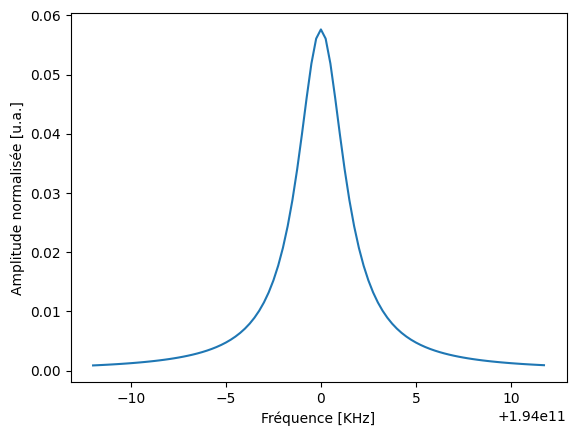

In [2]:
central_frequency = 194e12                                                         # 194 THz
frequency_linewidth = 3e3                                                          # 3 KHz

source = LightSource(
        frequency=central_frequency,
        frequency_linewidth=frequency_linewidth,
        power=1e-3,                                                                 # 1 mW = 0 dBm
        frequency_step=250,                                                         # 250 Hz
        bandwidth=8 * frequency_linewidth,
        shape="lorentzian",
    )

plt.plot(source.frequencies / 1e3, source.normalized_lineshape)
plt.xlabel("Fréquence [KHz]")
plt.ylabel("Amplitude normalisée [u.a.]")
plt.show()

## Génération de l'impulsion optique

On début avec une impulsion dite *sine-sloped*, et on la compare avec une impulsion carrée.

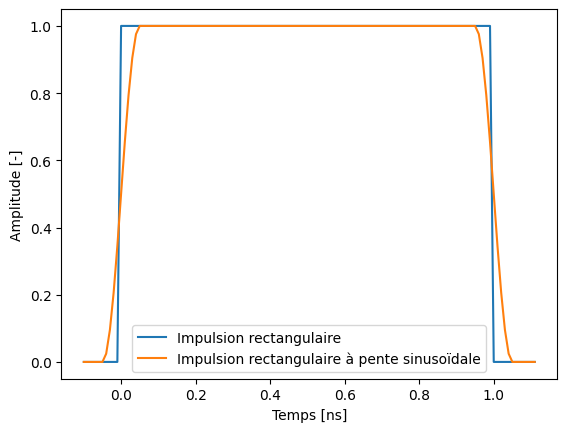

In [3]:
pulse_width = 1e-9        # 1 ns
segment_duration = 1e-11
rise_time = pulse_width / 10

time = omod.get_pulse_time_array(pulse_width, segment_duration, rise_time)

rec_pulse = omod.get_rectangular_pulse(pulse_width, time)
sine_pulse = omod.get_sine_rectangular_pulse(pulse_width, time, rise_time)

plt.plot()
plt.plot(time * 1e9, rec_pulse, label="Impulsion rectangulaire")
plt.plot(time * 1e9, sine_pulse, label="Impulsion rectangulaire à pente sinusoïdale")
plt.xlabel("Temps [ns]")
plt.ylabel("Amplitude [-]")
plt.legend()
plt.show()

L'impulsino optique aura donc la distribution temporelle et fréquentielle suivante.

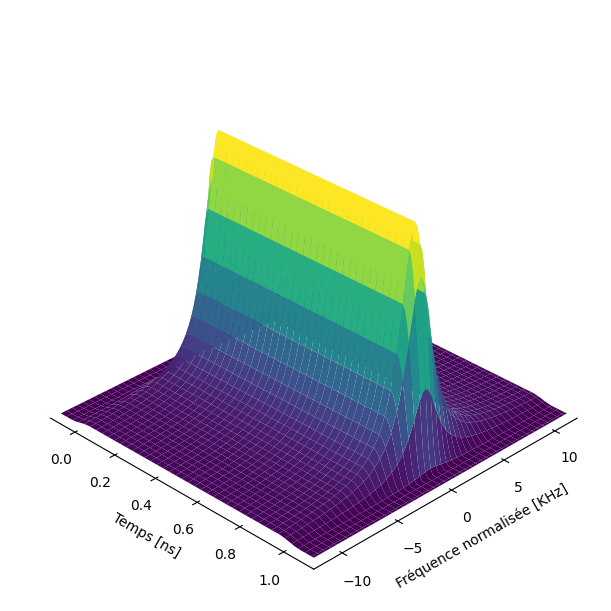

In [4]:
distribution = np.outer(source.normalized_lineshape, sine_pulse)
TIME, FREQ = np.meshgrid(time, source.frequencies, )

fig = plt.figure(figsize=(8, 6), layout="constrained")
ax = fig.add_subplot(111, projection='3d')

TIME *= 1e9
FREQ = (FREQ - source.frequency) / 1e3

ax.plot_surface(TIME, FREQ, distribution, cmap='viridis', linewidth=0)

ax.set_xlabel("Temps [ns]")
ax.set_ylabel("Fréquence normalisée [KHz]")
ax.set_xlim(TIME.min(), TIME.max())
ax.set_ylim(FREQ.min(), FREQ.max())

ax.set_facecolor('white')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_visible(False)
ax.zaxis.set_visible(False)
ax.zaxis.set(ticks=[])
ax.grid(visible=False)
ax.view_init(elev=30, azim=-45, roll=0)

plt.show()

# Construction de la fibre

On construit une fibre optique avec un indice de réfraction et une taille de segment variables.

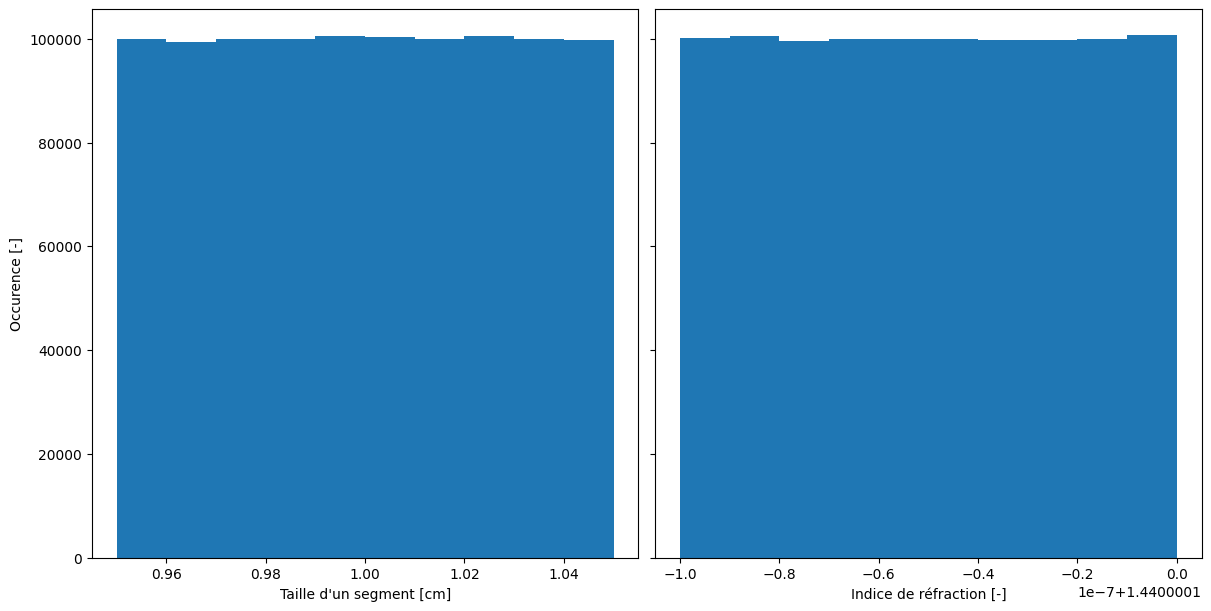

In [5]:
fiber = OpticalFiber(
    refractive_index=1.44,
    refractive_index_variation=1e-7,
    attenuation_coefficient=0.2,  # 0.2 dB / km
    segment_size=1e-2,  # 1 cm
    segment_size_variation=5,  # 5 %
    mode_field_diameter=2.13,
    average_backscattering_field_coefficient=70,
    length=10e3,  # 10 km
)

fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", sharey=True, figsize=(12,6))

ax1.hist(fiber.segment_sizes * 1e2)
ax1.set_xlabel("Taille d'un segment [cm]")
ax1.set_ylabel("Occurence [-]")

ax2.hist(fiber.refractive_indices)
ax2.set_xlabel("Indice de réfraction [-]")

plt.show()

## Calcul de la rétrodiffusion
On calcule maintenant la rétrodiffusion point par point, sans considérer l'impact de la tailled de l'impulsion, pour chaque fréquence.

In [6]:
def compute_propagating_phase(number_of_segments: np.ndarray, 
                              angular_wavenumbers: np.ndarray,
                              refractive_indices: np.ndarray,
                              segment_sizes: np.ndarray) -> np.ndarray:
    """Compute the phase propagetion"""
    phases = np.zeros((number_of_segments + 1, angular_wavenumbers.size))
    phases[1:] += np.cumsum(refractive_indices, axis=0)[:,None]
    phases[1:,:] *= angular_wavenumbers[None,:] * segment_sizes[:,None]

    return phases

def compute_electric_field(phases: np.ndarray,
                           segment_sizes: np.ndarray,
                           attenuation_coefficient: float,
                           segment_locations: np.ndarray,
                           refractive_indices: np.ndarray,
                           angular_wavenumbers: np.ndarray) -> np.ndarray:
    """Compute the backscattered electric field"""
    argument = (attenuation_coefficient + 1j * 2 * refractive_indices[:,None] * angular_wavenumbers[None,:])
    section_contribution = 2 * np.exp(-attenuation_coefficient * segment_locations[:,None]) * np.sinh(segment_sizes[:,None] / 2 * argument) / argument
    previous_phase = np.exp(1j * 2 * phases[:-1])

    return previous_phase * section_contribution

phases = compute_propagating_phase(fiber.number_of_segments,
                                   source.angular_wavenumbers,
                                   fiber.refractive_indices,
                                   fiber.segment_sizes)

fields = compute_electric_field(phases,
                                fiber.segment_sizes,
                                fiber.linear_attenuation_coefficient,
                                fiber.segment_locations,
                                fiber.refractive_indices,
                                source.angular_wavenumbers)

# Apply lineshpae
fields *= source.normalized_lineshape[None,:]

# Apply electric field
initial_electric_field = source.get_electric_field_amplitude(fiber.mode_field_diameter, fiber.refractive_index)
fields *= initial_electric_field

# Apply constants
fields *= fiber.mode_field_diameter * fiber.average_backscattering_field_coefficient

On applique maintenant le pulse.

In [7]:
# Applying probe pulse
fields_probed = omod.apply_pulse(fields, sine_pulse)

# Détection du signal

On détecte maintenant le signal avec un détecteur à bande passante limitée.

In [8]:
detector = Photodector(responsitivity=1,    # Ideal
                       bandwidth=100e6        # 100 MHz
)

current = detector.detect(fields_probed, fiber.segment_duration)

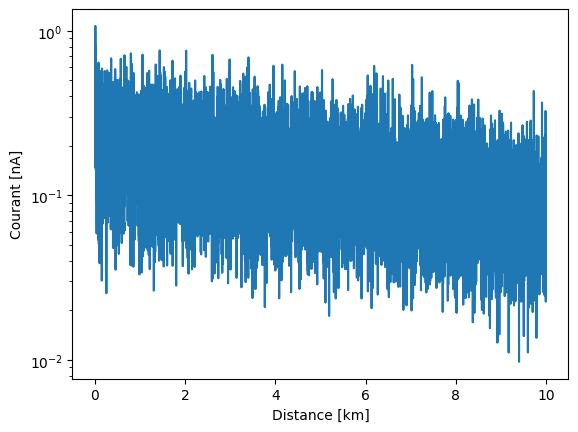

In [11]:
z = detector.crop_to_bandwidth(fiber.segment_locations, fiber.segment_duration)

plt.plot(z * 1e-3, current * 1e9)
plt.xlabel("Distance [km]")
plt.ylabel("Courant [nA]")
plt.yscale("log")
plt.show()